# Cross Entropy Method using Keras

This notebook is based on **Deep CEM** notebook and reimplements in using Keras.

**This is very slow**

https://gym.openai.com/envs/CartPole-v0/

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


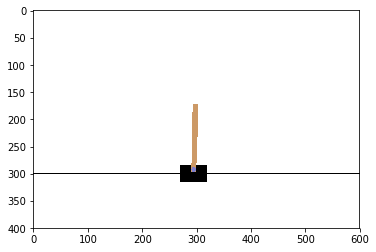

In [52]:
import numpy as np
import gym
import tensorflow as tf
from keras import models, layers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v1").env
env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))


# Create Agent

In [39]:
class CrossEntropyAgent:

    def __init__(self, env):
        """Initialize Keras model"""
        self.model = models.Sequential()
        self.model.add(layers.Dense(20, activation='relu', input_shape=env.observation_space.shape))
        self.model.add(layers.Dense(20, activation='relu'))
        self.model.add(layers.Dense(env.action_space.n, activation='softmax'))
        self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        # Initialize model
        self.update(np.array([env.reset()]*n_actions), np.eye(n_actions))
        
    def policy(self, state):
        """Policy function"""
        probs = self.model.predict(np.array([state]))
        return np.argmax(probs)
    
    def update(self, states, actions):
        """
        Update model based on given states and selected actions
        """
        self.model.fit(states, actions, epochs=1)

In [41]:
state = env.reset()
agent = CrossEntropyAgent(env)
agent.policy(state)

Epoch 1/1
2/2 [==============================] - 0s 206ms/step - loss: 0.6931 - acc: 0.5000


0

In [42]:
def generate_session(agent, time_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(time_max):
        
        # a vector of action probabilities in current state
        a = agent.policy(s) 
        
        new_s, r, done, info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done: break
    return states, actions, total_reward
        

In [44]:
agent = CrossEntropyAgent(env)
s,a,r = generate_session(agent)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float]

Epoch 1/1
2/2 [==============================] - 0s 212ms/step - loss: 0.6933 - acc: 0.5000


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a float32 vector.

In [45]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    xs = rewards_batch >= reward_threshold
    
    elite_states  = []
    elite_actions = []
    for i, v in enumerate(xs):
        if v:
            elite_states += states_batch[i]
            elite_actions += actions_batch[i]
    
    return elite_states, elite_actions
    

In [46]:
states_batch = [
    [1,2,3],   #game1
    [4,2,0,2], #game2
    [3,1]      #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = [
    3,         #game1
    4,         #game2
    5,         #game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_40 = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, rewards_batch, percentile=100)
assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


# Training loop
Generate sessions, select N best and fit to those.

In [47]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward, max_reward = np.mean(batch_rewards), np.max(batch_rewards)
    threshold = np.percentile(batch_rewards, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f, max=%.3f" % (mean_reward, threshold, max_reward))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards, range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()


mean reward = 79.340, threshold=82.000, max=410.000


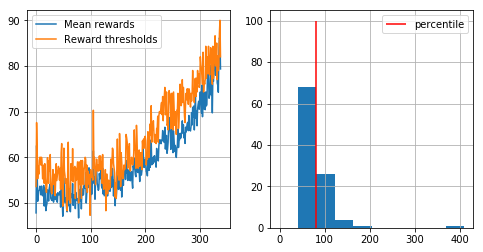

KeyboardInterrupt: 

In [55]:
n_sessions = 100
percentile = 70
log = []

agent = CrossEntropyAgent(env)

for i in range(2000):
    #generate new sessions
    sessions = [generate_session(agent) for _ in range(n_sessions)]

    batch_states,batch_actions,batch_rewards = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(batch_states, batch_actions, batch_rewards, percentile=percentile)
    
    states = np.array(elite_states)
    actions = to_categorical(elite_actions)
    
    agent.update(states, actions)

    show_progress(batch_rewards, log, percentile, reward_range=[0,np.max(batch_rewards)])
    
    if np.mean(batch_rewards)> 190:
        print("You Win! in {} steps".format(i+1))
        break